In [20]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [21]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [22]:
X_el = np.load('auxiliaries/electrodes.npy')
X_pac = np.load('auxiliaries/pac.npy')
Y = np.load('auxiliaries/labels.npy')
indices = np.arange(X_el.shape[0])

In [23]:
X_el.shape

(1050, 19, 400)

In [24]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 21])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [25]:
X_el = X_el.reshape(X_el.shape[0], X_el.shape[1], 1, 1, X_el.shape[-1])
X_pac = X_pac.reshape(X_pac.shape[0], 1, 1, 1, X_pac.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [26]:
X_el_train, X_el_test, y_train, y_test, indx_train, indx_test = train_test_split(X_el, Y, indices, test_size=0.30, random_state=42, stratify=Y)

In [27]:
X_el_train = torch.FloatTensor(X_el_train)
y_train = torch.FloatTensor(y_train)
target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 21, 1, 1, 1))
    
X_el_test = torch.FloatTensor(X_el_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 21, 1, 1, 1))

X_pac_train = torch.FloatTensor(X_pac[indx_train])
X_pac_test = torch.FloatTensor(X_pac[indx_test])

X_el_train.shape, y_train.shape, target_class_train.shape, X_pac_train.shape, X_pac_test.shape

(torch.Size([735, 19, 1, 1, 400]),
 torch.Size([735]),
 torch.Size([735, 21, 1, 1, 1]),
 torch.Size([735, 1, 1, 1, 8800]),
 torch.Size([315, 1, 1, 1, 8800]))

In [28]:
# %time
# m,n = X_el[0,:].squeeze().shape
# out = np.zeros((m,22*n),dtype=X_el.dtype)
# out[:,::22] = X_el[0,:].squeeze()
# out.shape

In [29]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 8800, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 8800,
            },
            "tgtSpikeCount": {True: 5000, False: 20},
        }
    },
}


In [30]:
X_el_train.shape, X_pac_train.shape

(torch.Size([735, 19, 1, 1, 400]), torch.Size([735, 1, 1, 1, 8800]))

In [31]:
train_dataset = torch.utils.data.TensorDataset(X_el_train, X_pac_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_el_test, X_pac_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [32]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size+1, hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def forward(self, input_el, input_pac):
        
        spike_el = self.slayer.spike(input_el)
        spike_pac = self.slayer.spike(input_pac)
        
        # impute with zero
        imputed_el = torch.zeros((spike_el.shape[0],spike_el.shape[1], 1,1,spike_el.shape[-1]*22))
        imputed_el[...,::22] = spike_el
        imputed_el = imputed_el.to(device)
        
        # merge with pac
        merged_data = torch.cat([imputed_el, spike_pac], 1)
        
        # el data
        spike2 = self.slayer.spike(self.slayer.psp(self.fc1(merged_data)))
        spike3 = self.slayer.spike(self.slayer.psp(self.fc2(spike2)))
        return spike3

In [33]:
device = torch.device("cuda:1")
net = SlayerMLP(params, 19, 64, 21).to(device)

In [34]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [35]:
148/len(train_dataset)

0.20136054421768707

In [36]:
train_losses=[]
train_accs = []
test_losses = []
test_accs = []
for epoch in range(301):
    net.train()
    correct = 0
    num_samples = 0
    loss_train = 0
    for i, (tact_el, tact_pac, target, label) in enumerate(train_loader):
        
        tact_el = tact_el.to(device)
        tact_pac = tact_pac.to(device)
        target = target.to(device)
        
        output = net.forward(tact_el, tact_pac)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        num_samples += len(label)
        loss = error.numSpikes(output, target)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss:', loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_losses.append(loss_train/len(train_dataset))
        
    net.eval()
    correct = 0
    num_samples = 0
    loss_test = 0
    with torch.no_grad():
        for i, (tact_el, tact_pac, target, label) in enumerate(test_loader):

            tact_el = tact_el.to(device)
            tact_pac = tact_pac.to(device)

            output = net.forward(tact_el, tact_pac)
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            num_samples += len(label)
            loss = error.numSpikes(output, target)
            loss_test += loss.item()
            
    if epoch%1 == 0:
        print('Test loss:', loss_test/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_losses.append(loss_test/len(test_dataset))

Epoch:  0  --------------------------
Train loss: 3773.6521006058674
Train accuracy: 0.047619047619047616
Test loss: 1644.0157180059523
Test accuracy: 0.047619047619047616
Test loss: 1320.1762261284723
Test accuracy: 0.09841269841269841
Test loss: 1290.2944971478175
Test accuracy: 0.13333333333333333
Test loss: 1283.2767554873512
Test accuracy: 0.15555555555555556
Test loss: 1272.3191437251985
Test accuracy: 0.19365079365079366
Test loss: 1261.2070126488095
Test accuracy: 0.1619047619047619
Test loss: 1256.3916651165675
Test accuracy: 0.18095238095238095
Test loss: 1245.2376302083333
Test accuracy: 0.18412698412698414
Test loss: 1238.5544108072916
Test accuracy: 0.2
Test loss: 1230.4055757068452
Test accuracy: 0.21587301587301588
Epoch:  10  --------------------------
Train loss: 1229.6206380208334
Train accuracy: 0.2054421768707483
Test loss: 1217.6697017609126
Test accuracy: 0.2126984126984127
Test loss: 1213.7688918340773
Test accuracy: 0.20952380952380953
Test loss: 1204.0049223400

Test loss: 994.2168426029266
Test accuracy: 0.5714285714285714
Test loss: 991.2284505208333
Test accuracy: 0.653968253968254
Test loss: 991.4985777839781
Test accuracy: 0.6444444444444445
Test loss: 988.6038426959325
Test accuracy: 0.6317460317460317
Test loss: 987.4160373263888
Test accuracy: 0.6222222222222222
Test loss: 986.3363994295635
Test accuracy: 0.6857142857142857
Test loss: 983.2471408420139
Test accuracy: 0.7047619047619048
Test loss: 982.4502503410218
Test accuracy: 0.653968253968254
Test loss: 981.9902328249008
Test accuracy: 0.6825396825396826
Test loss: 984.4374271453373
Test accuracy: 0.6349206349206349
Epoch:  120  --------------------------
Train loss: 977.0009373671344
Train accuracy: 0.6571428571428571
Test loss: 980.851578000992
Test accuracy: 0.6253968253968254
Test loss: 979.6941344246031
Test accuracy: 0.6634920634920635
Test loss: 978.6998922681051
Test accuracy: 0.6412698412698413
Test loss: 978.1081938244048
Test accuracy: 0.6095238095238096
Test loss: 977.7

Test loss: 923.1792286706349
Test accuracy: 0.6793650793650794
Test loss: 922.7742854042659
Test accuracy: 0.7333333333333333
Test loss: 921.6053610181052
Test accuracy: 0.692063492063492
Test loss: 920.8083441840278
Test accuracy: 0.6793650793650794
Test loss: 921.3903576078869
Test accuracy: 0.707936507936508
Test loss: 923.7827365451388
Test accuracy: 0.6634920634920635
Test loss: 921.2015749007936
Test accuracy: 0.7587301587301587
Epoch:  230  --------------------------
Train loss: 912.1878939466411
Train accuracy: 0.7251700680272108
Test loss: 920.702283296131
Test accuracy: 0.6634920634920635
Test loss: 918.0839967757937
Test accuracy: 0.7333333333333333
Test loss: 918.3850492931548
Test accuracy: 0.7365079365079366
Test loss: 917.4808772011409
Test accuracy: 0.7111111111111111
Test loss: 918.9408334883433
Test accuracy: 0.7365079365079366
Test loss: 917.6647770957342
Test accuracy: 0.7587301587301587
Test loss: 916.9265090215774
Test accuracy: 0.7619047619047619
Test loss: 915.6

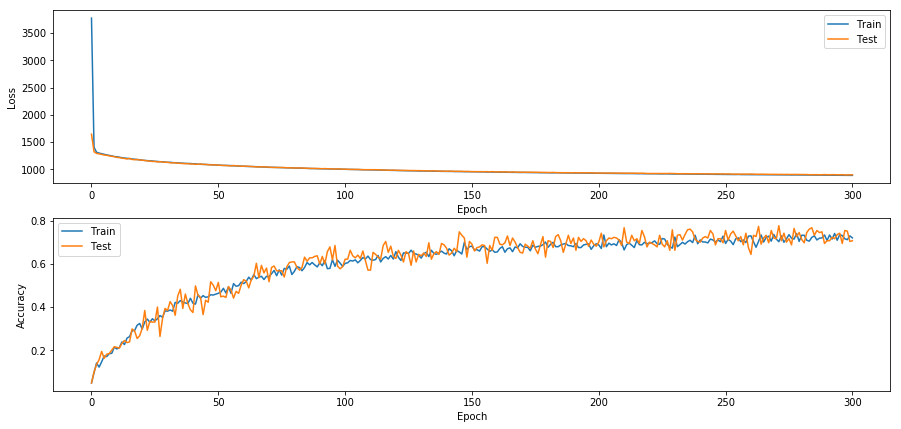

In [37]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [38]:
np.max(test_accs)

0.7777777777777778

In [39]:
np.max(train_accs)

0.7414965986394558